By [Kevin Michalewicz](https://kevinmichalewicz.com) on April 2023

This notebook details how to pre-process antibody structures to obtain aligned normal mode correlation maps. After that, training and evaluation using the ANTIPASTI model is explained.

In [1]:
# General imports
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import CenteredNorm

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief
from torch.nn import MSELoss
from torchmetrics import PearsonCorrCoef

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.torch_utils import create_test_set, save_checkpoint, training_routine

# Pre-processing

In [2]:
modes = 30 # Number of normal modes to consider. Relevant if renew_maps is True
renew_maps = False # True to compute again all the normal mode correlation maps
renew_residues = False # True to retrieve again all the chain lengths 
mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
regions = 'heavy' # 'paired_hl' or 'heavy'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']

preprocessed_data = Preprocessing(modes=modes, regions=regions, pathological=pathological, renew_maps=renew_maps, renew_residues=renew_residues, mode=mode)

Let's plot some histograms to see the distributions of the chain lengths and the binding affinities.

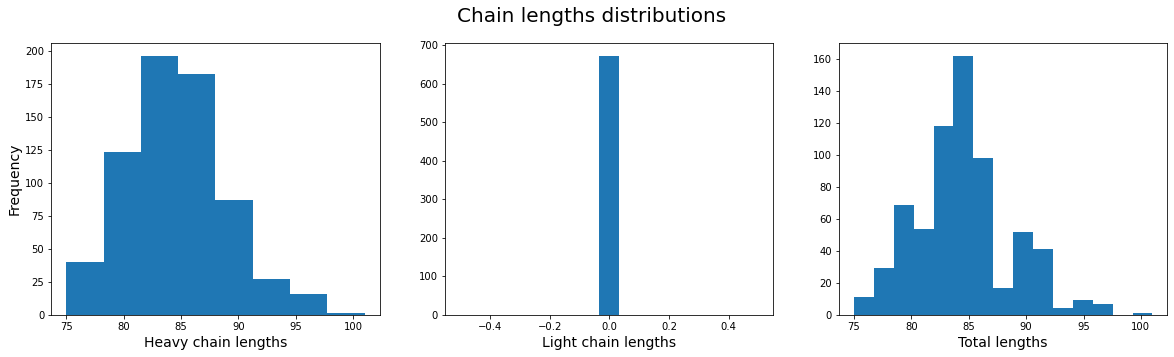

In [3]:
title_size = 20
font_size = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Chain lengths distributions', size=title_size)
ax1.hist(preprocessed_data.heavy, 8)
ax2.hist(preprocessed_data.light, 15)
ax3.hist([sum(x) for x in zip(preprocessed_data.heavy, preprocessed_data.light)], 15)

# Changing plotting settings
ax1.set_ylabel('Frequency', size=font_size)
ax1.set_xlabel('Heavy chain lengths', size=font_size)
ax2.set_xlabel('Light chain lengths', size=font_size)
ax3.set_xlabel('Total lengths', size=font_size)

plt.show()

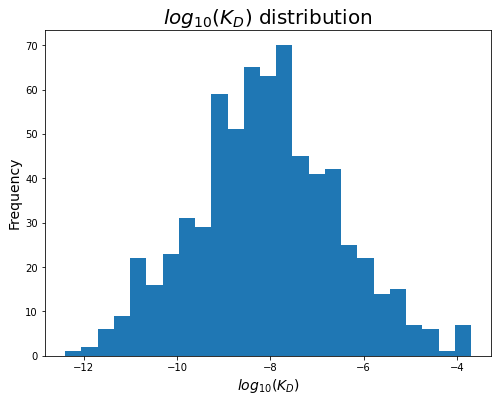

In [4]:
fig = plt.figure(figsize=(8, 6))
plt.title('$log_{10}(K_D)$ distribution', size=title_size)
plt.hist(preprocessed_data.train_y, 25)
plt.xlabel('$log_{10}(K_D)$', size=font_size)
plt.ylabel('Frequency', size=font_size)
plt.show()

A sample normal mode correlation map before and after adding the blank pixels.

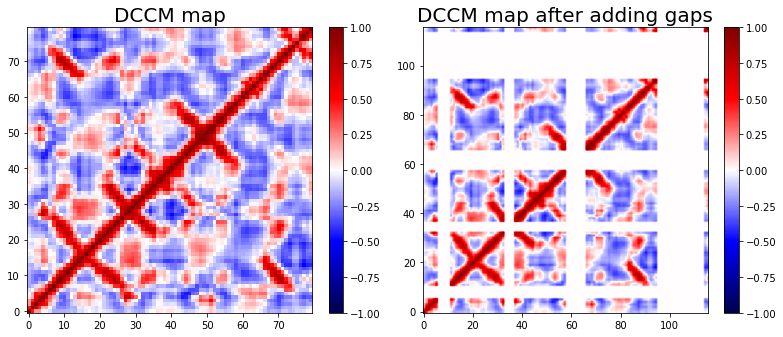

In [5]:
input_shape = preprocessed_data.train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(preprocessed_data.raw_imgs[74], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(preprocessed_data.train_x[74].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

plt.colorbar(im1, ax=ax1, fraction=0.045)
plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [6]:
# The test set is generated
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(preprocessed_data.train_x, preprocessed_data.train_y)

In [8]:
idx_te

array([141, 574, 604, 322, 471, 284,  91, 410, 250,  62,  44, 116, 447,
       146, 349, 389])

In [9]:
preprocessed_data.train_x[idx_te]

array([[[ 1.        ,  0.52262563,  0.19242686, ...,  0.        ,
         -0.02036213,  0.02308489],
        [ 0.52262563,  1.        ,  0.64326783, ...,  0.        ,
         -0.06297227, -0.01068362],
        [ 0.19242686,  0.64326783,  1.        , ...,  0.        ,
         -0.18189426, -0.13095706],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.02036213, -0.06297227, -0.18189426, ...,  0.        ,
          1.        ,  0.70319521],
        [ 0.02308489, -0.01068362, -0.13095706, ...,  0.        ,
          0.70319521,  1.        ]],

       [[ 1.        ,  0.39337696,  0.28787933, ...,  0.        ,
          0.00184803,  0.02905152],
        [ 0.39337696,  1.        ,  0.68460953, ...,  0.        ,
         -0.02294015,  0.00240446],
        [ 0.28787933,  0.68460953,  1.        , ...,  0.        ,
         -0.11327977, -0.07572815],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [10]:
preprocessed_data.train_y[idx_te]

array([-11.167491 ,  -7.7212462,  -7.275724 ,  -6.3809066,  -7.0772743,
        -9.522879 ,  -8.       ,  -8.447331 ,  -8.60206  ,  -5.920819 ,
        -6.229148 ,  -6.5086384, -10.707744 ,  -7.69897  ,  -7.69897  ,
        -8.686132 ], dtype=float32)

In [13]:
np.array(preprocessed_data.labels)[idx_te]

array(['2nz9', '5vpg', '6a0z', '4ffz', '5dd0', '3u0t', '1zv5', '4w6w',
       '3l95', '1oay', '1m7d', '2hkf', '5alb', '2p44', '4jan', '4odx'],
      dtype='<U4')

In [ ]:
# Hyperparameters
n_filters = 1
filter_size = 4
pooling_size = 2
learning_rate = 0.00027253018778843 * 2.5

# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape)
criterion = MSELoss() #-PearsonCorrCoef()
optimiser = AdaBelief(model.parameters(), lr=learning_rate, eps=1e-8, print_change_log=False) 

print(model)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

In [ ]:
#{'learning_rate': 0.00027253018778843, 'n_max_epochs': 65, 'pooling_size': 1, 'filter_size': 4, 'n_filters': 4}
#{'learning_rate': 0.0008657756272162166, 'n_max_epochs': 82, 'pooling_size': 1, 'filter_size': 5, 'n_filters': 1}. Best is trial 30 with value: 1.0617385705312092.

# Training

In [11]:
train_losses = []
test_losses = []

In [121]:
n_max_epochs = 150
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor([[-9.5634]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.8050]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.2712]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.2634]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.6298]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.7579]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.5892]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.2659]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.0450]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.4465]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.1171]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.8431]], grad_fn=<MmBack

tensor([[-9.4599]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6597]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.1016]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.3551]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-9.0962]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.6823]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.9441]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.5361]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.1665]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2281]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.2776]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.4974]], grad_fn=<MmBack

tensor([[-9.9157]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.1538]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.7525]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.3580]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.2251]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.3431]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.6121]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-9.2199]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7261]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.8643]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.2474]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.5199]], grad_fn=<MmBack

tensor([[-10.7715]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0462]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.8529]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.2068]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.2356]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.3974]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.5231]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.7240]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.9673]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.7463]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.7279]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.5642]], grad_fn=<MmBac

tensor([[-9.9829]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-6.9166]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.7777]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.2566]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.3431]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.5911]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.2217]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6482]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.6575]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.6171]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.5514]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.7256]], grad_fn=<MmBack

tensor([[-10.6362]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0354]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.3677]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.2747]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.7359]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.9006]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.4395]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5058]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.4496]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.7157]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.9786]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.2145]], grad_fn=<MmBac

tensor([[-10.6586]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0339]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.6162]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.8233]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.5279]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.1004]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.3726]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.8797]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7741]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.9548]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.1669]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.7139]], grad_fn=<MmBac

tensor([[-9.5572]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.1076]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.5228]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.1332]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.6577]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.1230]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.4055]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5244]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.9410]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2910]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.9888]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.1110]], grad_fn=<MmBack

tensor([[-9.8229]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.1752]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.4917]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.9242]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.5630]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-7.9194]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.8513]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.5648]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-7.8407]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.8580]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.3305]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.1375]], grad_fn=<MmBack

tensor([[-10.1188]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0793]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.4240]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.3169]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.8714]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.9413]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.9904]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4148]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.4205]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.3685]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.8100]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.8921]], grad_fn=<MmBac

tensor([[-10.9267]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0947]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.2061]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.7224]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.6883]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.9375]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.6923]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4239]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.1137]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.8295]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.2539]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.7792]], grad_fn=<MmBac

tensor([[-10.2014]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.9942]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.3242]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.0712]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.7095]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.5453]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.2943]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.4703]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.0689]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.3390]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.5113]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.4812]], grad_fn=<MmBac

tensor([[-10.7021]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.6458]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.2969]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.6532]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.6464]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.8265]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.5880]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-9.1975]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.1792]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.6580]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.0893]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.9688]], grad_fn=<MmBac

tensor([[-10.0528]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.1403]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.1985]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.7255]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.8148]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.9841]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.7028]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.9909]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.0232]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2904]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.8042]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-9.4749]], grad_fn=<MmBac

tensor([[-10.2472]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6273]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.0597]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.6939]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.6405]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.0200]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.6675]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.6489]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7799]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.2998]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.0219]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.6899]], grad_fn=<MmBac

tensor([[-9.5827]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.7145]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.2893]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.7789]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.3966]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.5470]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.6971]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-7.9699]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7785]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2772]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.7367]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.0590]], grad_fn=<MmBack

tensor([[-9.6427]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.8377]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.5715]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.5644]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.7034]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.8687]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.5863]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3073]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.0057]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.2679]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.0240]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.5745]], grad_fn=<MmBack

tensor([[-10.6747]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.6766]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.4305]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.5284]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.6222]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.6482]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.7939]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-9.1311]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.6429]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.8660]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.1841]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.3982]], grad_fn=<MmBac

tensor([[-10.4096]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.8408]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.8388]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.4965]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.9996]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.0979]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.2547]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.5995]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.9664]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.4457]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.1681]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.2191]], grad_fn=<MmBac

tensor([[-10.8732]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.2901]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7311]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.6877]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.9111]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.7665]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.0798]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.3747]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-9.0058]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.1811]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.2805]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.6978]], grad_fn=<MmBac

tensor([[-9.9973]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.8240]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.1797]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.1519]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.3035]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.8697]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.9058]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.8773]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7209]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.3806]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.1291]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.6263]], grad_fn=<MmBack

tensor([[-9.4581]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.9965]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.7901]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.7899]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-9.0048]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-9.5157]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.1608]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.2523]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.1268]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.2282]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-7.2850]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.8135]], grad_fn=<MmBack

tensor([[-9.9163]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.4817]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.4045]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.2569]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.9230]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-10.0876]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-6.9555]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.0834]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.7844]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-7.3364]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.3867]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-8.2208]], grad_fn=<MmBac

tensor([[-10.1071]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-7.5162]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-6.4281]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-8.3676]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-8.4229]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.6554]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-8.3071]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.8097]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.0691]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-5.6291]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-6.4164]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-9.2139]], grad_fn=<MmBac

tensor([[-10.2107]], grad_fn=<MmBackward0>)
tensor([[-11.1675]])
------------------------
tensor([[-8.0792]], grad_fn=<MmBackward0>)
tensor([[-7.7212]])
------------------------
tensor([[-7.5693]], grad_fn=<MmBackward0>)
tensor([[-7.2757]])
------------------------
tensor([[-7.8729]], grad_fn=<MmBackward0>)
tensor([[-6.3809]])
------------------------
tensor([[-7.2095]], grad_fn=<MmBackward0>)
tensor([[-7.0773]])
------------------------
tensor([[-8.5865]], grad_fn=<MmBackward0>)
tensor([[-9.5229]])
------------------------
tensor([[-7.8780]], grad_fn=<MmBackward0>)
tensor([[-8.]])
------------------------
tensor([[-8.2104]], grad_fn=<MmBackward0>)
tensor([[-8.4473]])
------------------------
tensor([[-8.6066]], grad_fn=<MmBackward0>)
tensor([[-8.6021]])
------------------------
tensor([[-6.5540]], grad_fn=<MmBackward0>)
tensor([[-5.9208]])
------------------------
tensor([[-5.5013]], grad_fn=<MmBackward0>)
tensor([[-6.2291]])
------------------------
tensor([[-7.9441]], grad_fn=<MmBac

In [110]:
#optimiser.param_groups[0]['lr'] = 5e-4

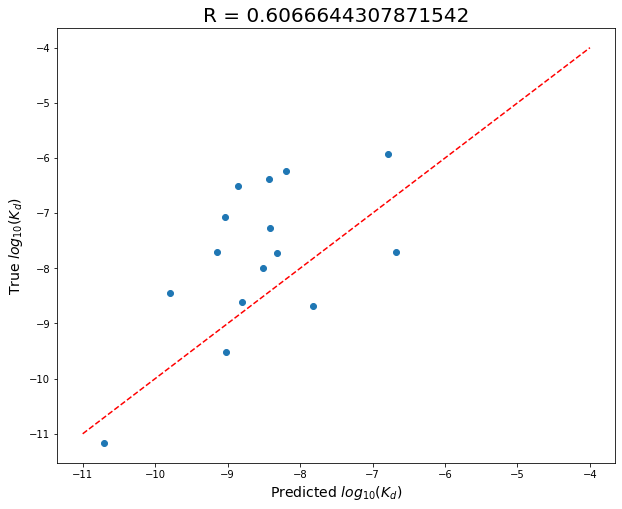

In [113]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(output_test[:,0].detach().numpy(), y_test[:,0].detach().numpy())
corr = np.corrcoef(output_test[:,0].detach().numpy().T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

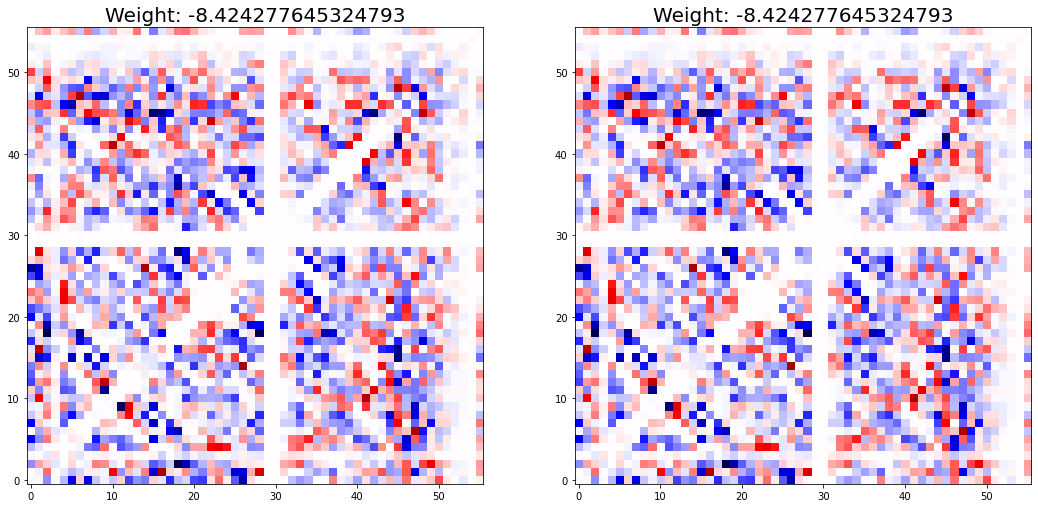

In [114]:
fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(18, 20))
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
learnt_filter = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = learnt_filter
    else:
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        learnt_filter += im_
    im = axs[j].imshow(im_, origin='lower', cmap='seismic', norm=CenteredNorm())
    axs[j].set_title('Weight: '+str(im_.sum()), size=title_size)

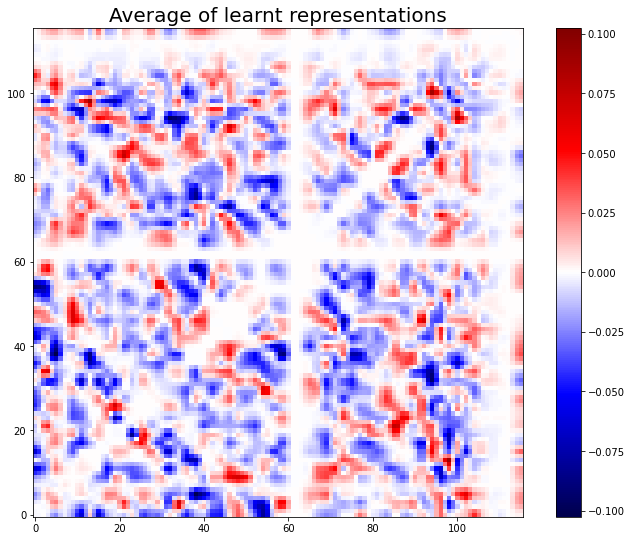

In [115]:
fig = plt.figure(figsize=(12, 9))
plt.imshow(cv2.resize(learnt_filter, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower', cmap='seismic', norm=CenteredNorm())
plt.title('Average of learnt representations', size=title_size)
plt.colorbar()
plt.show()

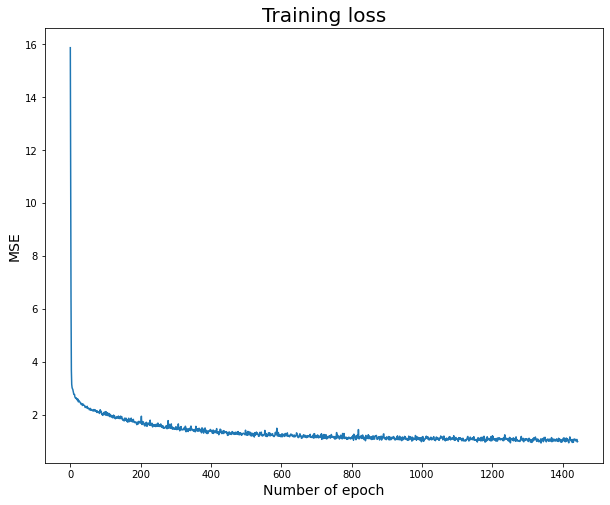

In [116]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

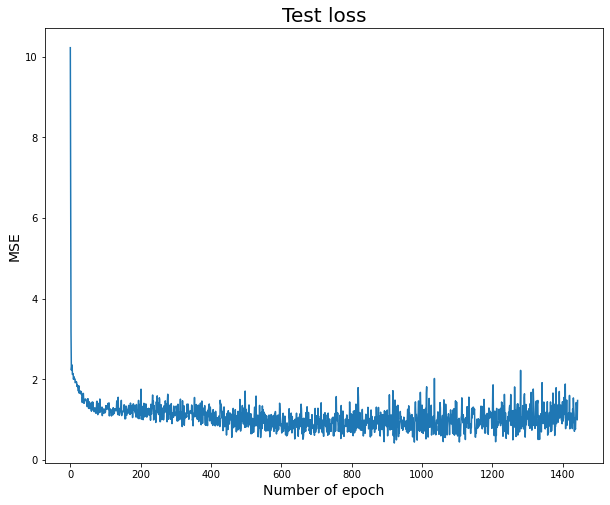

In [117]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i].detach().numpy() for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

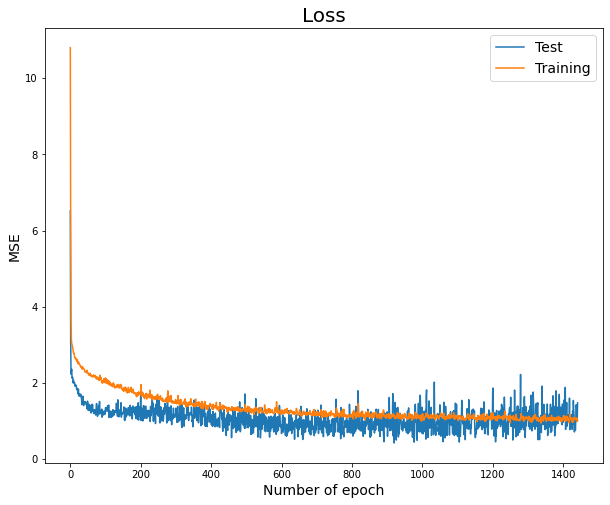

In [118]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[1:][i].detach().numpy() for i in range(len(test_losses[1:]))])
plt.plot([train_losses[1:][i] for i in range(len(train_losses[1:]))])
plt.title('Loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.legend(['Test', 'Training'], prop={'size': font_size})
plt.show()

In [119]:
model(train_x[40:80])[0]

tensor([[ -8.7011],
        [ -8.3279],
        [ -8.8603],
        [ -8.1409],
        [ -7.2932],
        [ -8.0969],
        [ -7.1696],
        [ -8.0779],
        [ -9.9343],
        [ -7.7178],
        [ -9.2965],
        [ -8.9835],
        [-11.0999],
        [ -9.0444],
        [ -9.0879],
        [ -9.4286],
        [ -7.2698],
        [ -8.2898],
        [ -8.4941],
        [ -9.2594],
        [ -8.7759],
        [-10.1675],
        [ -8.2613],
        [ -9.5839],
        [ -7.3650],
        [ -8.7254],
        [ -8.6076],
        [ -9.0944],
        [ -7.2963],
        [ -8.7038],
        [ -6.2074],
        [ -7.3639],
        [ -8.9771],
        [-10.3376],
        [ -6.7722],
        [ -6.9953],
        [ -7.7637],
        [ -6.9120],
        [ -7.5467],
        [ -7.4827]], grad_fn=<MmBackward0>)

In [120]:
train_y[40:80]

tensor([[ -9.0269],
        [ -6.7905],
        [ -9.1759],
        [ -5.3098],
        [ -7.0269],
        [ -6.8539],
        [ -5.7959],
        [ -8.4815],
        [-10.7447],
        [ -8.7645],
        [ -8.5935],
        [ -9.5686],
        [-11.6021],
        [ -8.3010],
        [ -8.2218],
        [ -7.0605],
        [ -6.7799],
        [ -7.7212],
        [ -8.2218],
        [ -8.1871],
        [ -8.1141],
        [-11.2441],
        [ -7.6576],
        [ -9.5376],
        [ -7.3279],
        [ -6.6198],
        [ -6.5391],
        [ -7.8539],
        [ -7.7696],
        [ -8.2518],
        [ -7.0000],
        [ -5.3279],
        [ -6.3872],
        [-10.2676],
        [ -5.0555],
        [ -5.7959],
        [ -8.2147],
        [ -4.6198],
        [ -7.5528],
        [ -6.2218]])

In [89]:
##### Uncomment the following lines to save a checkpoint

#path = '../checkpoints/model_' + regions + '_epochs_' + str(len(train_losses)) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
#save_checkpoint(path, model, optimiser, train_losses, test_losses)
#np.save('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(len(train_losses))+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy', learnt_filter)

In [1097]:
##### Uncomment the following lines to load a checkpoint

from antipasti.utils.torch_utils import load_checkpoint
#
path = '../checkpoints/model_' + regions + '_epochs_' + str(159) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model,_,_,train_losses, test_losses = load_checkpoint(path, input_shape)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
